# **Empirical Notebook 02: Credit Risk and Autonomy V2.2**

## **Section 1 - Imports and Configuration**
This section loads all required libraries, sets global configurations, and prepares directories for outputs and figures.

In [1]:
# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# System and numerical libraries
import os
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Metrics and calibration
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve

# Model interpretation and statistics
import shap
import statsmodels.api as sm

# Utilities
from tqdm.auto import tqdm
import joblib

# Global settings
np.random.seed(42)
os.makedirs("figures", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

### **Environment Information**

We display the current session information to ensure reproducibility of the analysis.

In [2]:
import session_info
session_info.show()

## **Section 2 - Load Dataset and Sanity Checks**

This section loads the financial dataset (version 3.2) and performs basic checks to ensure data integrity.

In [3]:
# Load dataset
df = pd.read_csv("DatasetFinanceiro_v3.2.csv")

# Shape and preview
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Dataset shape: (10000, 38)
Columns: ['idade', 'estado_civil', 'escolaridade', 'renda_estim', 'regiao', 'tipo_emprego', 'tempo_emprego', 'num_cartoes', 'limite_total', 'utilizacao_media', 'historico_atrasos', 'score_credito', 'divida_renda', 'quant_transacoes', 'valor_medio_trans', 'compra_internacional', 'assinaturas', 'transacoes_incomuns', 'prob_inadimplencia', 'fraude_simulada', 'comportamento_suspeito', 'anomalia_padrao', 'A', 'O', 'H', 'S_raw', 'S_norm', 'log1pS', 'A_sq', 'A_times_O', 'A2_logS', 'conf_modelo', 'label_default', 'entropia_pred', 'variabilidade_pred', 'drift_score', 'sexo', 'raca']


,idade,estado_civil,escolaridade,renda_estim,regiao,tipo_emprego,tempo_emprego,num_cartoes,limite_total,utilizacao_media,...,A_sq,A_times_O,A2_logS,conf_modelo,label_default,entropia_pred,variabilidade_pred,drift_score,sexo,raca
0,45.960570,solteiro,fundamental,3292.988587,sudeste,clt,1.490885,3,12399.152432,0.289483,...,0.000069,0.004189,0.000005,0.431438,0,0.096900,0.069658,0.076812,feminino,branca
1,38.340828,solteiro,medio,1318.066261,nordeste,clt,8.287529,3,5586.978596,0.380147,...,0.083224,0.111108,0.026206,0.493034,0,0.128550,0.026706,0.058620,feminino,parda
2,47.772262,solteiro,pos,2580.672825,sudeste,desempregado,11.313190,3,7381.248391,0.343940,...,0.022817,0.065149,0.005168,0.464883,0,0.216693,0.068442,0.125284,feminino,parda
3,58.276358,solteiro,superior,1533.976251,nordeste,clt,16.081947,1,3660.305124,0.144685,...,0.076313,0.145576,0.035576,0.500190,0,0.069461,0.065740,0.044536,masculino,parda
4,37.190160,casado,medio,1218.687502,centro-oeste,clt,10.198240,2,5004.534675,0.391849,...,0.039450,0.085077,0.014982,0.462938,0,0.130632,0.059859,0.014876,masculino,parda


## **Section 3 - Exploratory Data Analysis (EDA)**

We analyze the distribution of default probability and correlations among key theoretical variables.

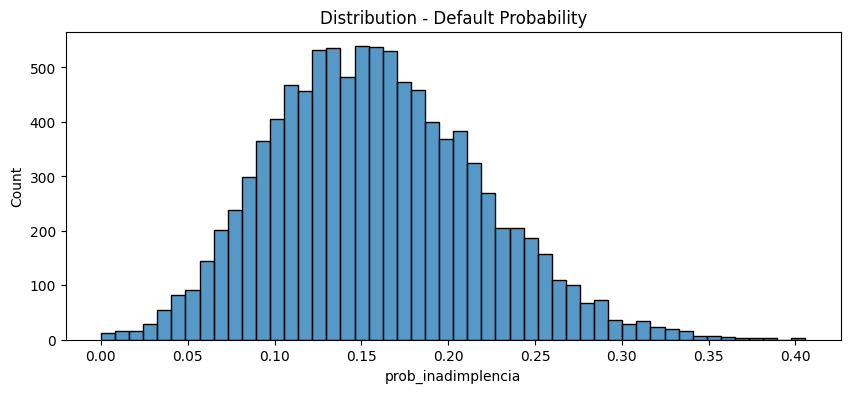

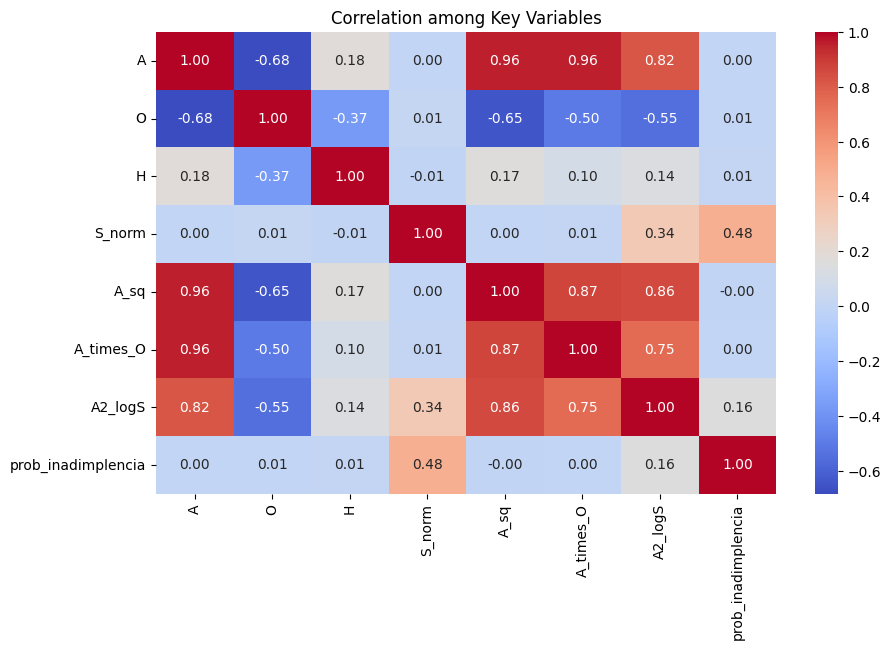

In [4]:
# Distribution of default probability
plt.figure(figsize=(10,4))
sns.histplot(df['prob_inadimplencia'], bins=50)
plt.title('Distribution - Default Probability')
plt.savefig('figures/dist_prob_inad.png', bbox_inches='tight')
plt.show()

# Correlation heatmap
corr = df[['A','O','H','S_norm','A_sq','A_times_O','A2_logS','prob_inadimplencia']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation among Key Variables')
plt.savefig('figures/corr_teoricas.png', bbox_inches='tight')
plt.show()

## **Section 4 - Data Preparation**

We define the target variable (`label_default`), select theoretical features, and split the dataset into training and testing sets.

In [5]:
# Create label (~10% positives)
threshold = df['prob_inadimplencia'].quantile(0.90)
df['label_default'] = (df['prob_inadimplencia'] > threshold).astype(int)

print("Label distribution:")
print(df['label_default'].value_counts())
print(df['label_default'].value_counts(normalize=True))

# Features
features_theory = ['A','A_sq','O','H','log1pS','A_times_O','A2_logS']
X = df[features_theory]
y = df['label_default']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

Label distribution:
label_default
0    9000
1    1000
Name: count, dtype: int64
label_default
0    0.9
1    0.1
Name: proportion, dtype: float64


## **Section 5 - Baseline Models (Logistic Regression, Random Forest, XGBoost)**

In this section, we train three baseline models to predict credit default:

* Logistic Regression
* Random Forest
* XGBoost

We then evaluate them using AUC (Area Under the ROC Curve) and Brier Score.

In [6]:
# 5.1 Logistic Regression
log_mod = LogisticRegression(max_iter=3000).fit(X_train, y_train)
joblib.dump(log_mod, "outputs/log_mod.joblib")

# 5.2 Random Forest
rf_mod = RandomForestClassifier(n_estimators=300, random_state=42).fit(X_train, y_train)
joblib.dump(rf_mod, "outputs/rf_mod.joblib")

# 5.3 XGBoost - adjusted base_score
xgb_mod = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    base_score=0.5,
    random_state=42
)
xgb_mod.fit(X_train, y_train)
joblib.dump(xgb_mod, "outputs/xgb_mod.joblib")

['outputs/xgb_mod.joblib']

### **Model Evaluation**

We compute AUC and Brier Score for each baseline model on the test set.

In [7]:
for name, model in [("LogReg", log_mod), ("RF", rf_mod), ("XGB", xgb_mod)]:
    p = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p)
    brier = brier_score_loss(y_test, p)
    print(f"{name} - AUC={auc:.4f} - Brier={brier:.4f}")

LogReg - AUC=0.7763 - Brier=0.0777
RF - AUC=0.7322 - Brier=0.0822
XGB - AUC=0.7504 - Brier=0.0807


## **Section 6 - Autonomy Buckets (Default Rate by Autonomy Levels)**

In this section, the variable **A (Autonomy)** is grouped into 5 ranges based on quantiles.

Then, the average probability of default and the average default rate are calculated for each range, highlighting how credit risk varies between levels of autonomy.

          prob_mean  default_rate  count
A_bucket                                
0          0.157492        0.0910   2000
1          0.159135        0.0990   2000
2          0.156651        0.1010   2000
3          0.158672        0.0985   2000
4          0.158999        0.1105   2000


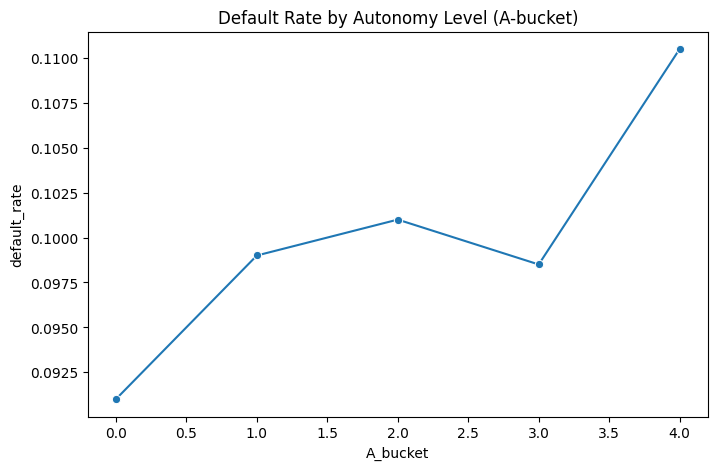

In [11]:
# Create autonomy buckets (5 quantiles)
df['A_bucket'] = pd.qcut(df['A'], q=5, labels=False)

# Aggregate statistics by bucket
bucket_stats = df.groupby('A_bucket').agg(
    prob_mean=('prob_inadimplencia','mean'),
    default_rate=('label_default','mean'),
    count=('label_default','size')
)

print(bucket_stats)

# Plot default rate by autonomy bucket
plt.figure(figsize=(8,5))
sns.lineplot(data=bucket_stats, x=bucket_stats.index, y='default_rate', marker='o')
plt.title('Default Rate by Autonomy Level (A-bucket)')
plt.savefig('figures/A_bucket_default_rate.png', bbox_inches='tight')
plt.show()

## **Section 7 - Calibration (Expected Calibration Error, ECE)**

This section evaluates the calibration of the reference models using the Expected Calibration Error (ECE).

The calibration by autonomy levels is also analyzed to verify if the risk estimate varies between them.

In [12]:
# Function to compute Expected Calibration Error (ECE)
def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    ece = 0
    for i in range(n_bins):
        mask = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if mask.sum() > 0:
            ece += (mask.sum()/len(y_prob)) * abs(y_prob[mask].mean() - y_true[mask].mean())
    return ece

# ECE by model
for name, model in [("LogReg", log_mod), ("RF", rf_mod), ("XGB", xgb_mod)]:
    p = model.predict_proba(X_test)[:,1]
    ece = compute_ece(y_test.values, p)
    print(f"{name} - ECE={ece:.4f}")

LogReg - ECE=0.0137
RF - ECE=0.0277
XGB - ECE=0.0199


### **Calibration by Autonomy Buckets**

Here, the ECE is calculated for each range level using the XGBoost model to analyze the calibration between the different range levels.

0    0.034965
1    0.013874
2    0.025356
3    0.022430
4    0.044491
dtype: float64


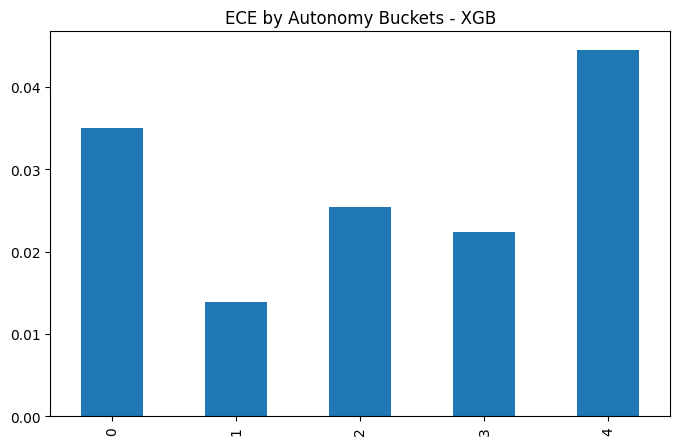

In [13]:
# Add autonomy buckets to test set
X_test_full = X_test.copy()
X_test_full['A_bucket'] = pd.qcut(X_test_full['A'], q=5, labels=False)
X_test_full['p'] = xgb_mod.predict_proba(X_test)[:,1]

# Compute ECE by bucket
ece_by_bucket = {}
for bucket in sorted(X_test_full['A_bucket'].unique()):
    g = X_test_full[X_test_full['A_bucket'] == bucket]
    y_true_g = y_test.loc[g.index].values
    y_prob_g = g['p'].values
    ece_by_bucket[bucket] = compute_ece(y_true_g, y_prob_g)

ece_by_bucket = pd.Series(ece_by_bucket)
print(ece_by_bucket)

# Plot ECE by autonomy bucket
plt.figure(figsize=(8,5))
ece_by_bucket.plot(kind='bar')
plt.title('ECE by Autonomy Buckets - XGB')
plt.savefig('figures/ECE_A_buckets.png', bbox_inches='tight')
plt.show()

## **Section 8 - SHAP Interaction Analysis**

In this section, SHAP (SHapley Additive exPlanations) is used to analyze the theoretical interactions between autonomy (A), obligation (O), and their transformations.

This helps to understand how interactions between variables contribute to credit default risk.

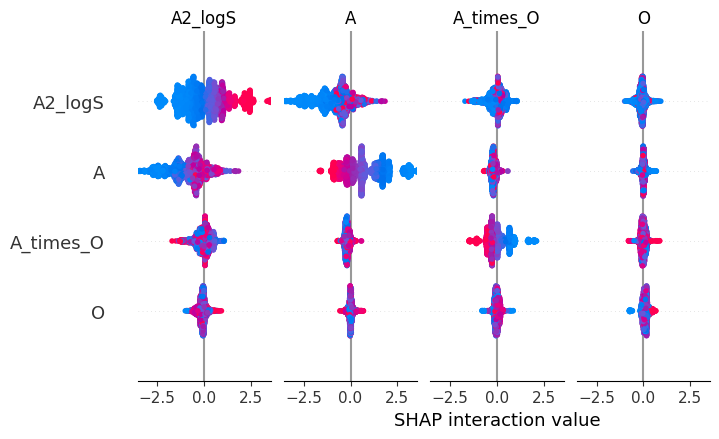

<Figure size 640x480 with 0 Axes>

In [14]:
# Select features for interaction analysis
features_inter = ['A','O','A_times_O','A2_logS']
X_train_inter = X_train[features_inter]
X_test_inter = X_test[features_inter]

# Train XGBoost model for interaction analysis
xgb_inter = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    base_score=0.5,
    random_state=42
)
xgb_inter.fit(X_train_inter, y_train)

# SHAP TreeExplainer in robust mode
explainer = shap.TreeExplainer(
    xgb_inter,
    feature_perturbation="tree_path_dependent"
)

# Ensure float dtype to avoid warnings
X_test_inter = X_test_inter.astype(float)

# Compute SHAP interaction values
shap_inter = explainer.shap_interaction_values(X_test_inter)

# Plot SHAP interactions
shap.summary_plot(
    shap_inter,
    X_test_inter,
    max_display=10,
    plot_type='dot'
)
plt.savefig("figures/shap_interactions.png", bbox_inches='tight')
plt.show()

## **Section 9 - Bootstrap Confidence Intervals (Logit)**

In this section, confidence intervals for the coefficients of a logistic regression model are estimated using bootstrap resampling (800 iterations). This provides statistical robustness to the theoretical features.

In [15]:
# Features for bootstrap analysis
features_boot = ['A_sq','A_times_O','A2_logS']
Xb = sm.add_constant(df[features_boot])
yb = df['label_default'].values

coefs = []

# Bootstrap with 800 iterations
for _ in tqdm(range(800)):
    idx = np.random.choice(len(df), len(df), replace=True)
    X_res = Xb.iloc[idx]
    y_res = yb[idx]
    try:
        mod = sm.Logit(y_res, X_res).fit(disp=0)
        coefs.append(mod.params.values)
    except:
        pass

# Convert to array
coefs = np.array(coefs)

# Compute mean and confidence intervals
means = coefs.mean(axis=0)
ic_low = np.percentile(coefs, 2.5, axis=0)
ic_high = np.percentile(coefs, 97.5, axis=0)

# Build results table
bootstrap_table = pd.DataFrame({
    'feature': ['const'] + features_boot,
    'mean': means,
    'IC_low': ic_low,
    'IC_high': ic_high
})

# Save results
bootstrap_table.to_csv('outputs/bootstrap_table.csv', index=False)
bootstrap_table

  0%|          | 0/800 [00:00<?, ?it/s]

,feature,mean,IC_low,IC_high
0,const,-2.321862,-2.548534,-2.103106
1,A_sq,-23.274270,-28.503533,-18.675676
2,A_times_O,3.926729,0.627813,7.477651
3,A2_logS,49.740766,42.368538,58.669784


## **Section 10 - Sensitivity & Permutation Test**

In this section, two analyses are performed:

* **1 - Sensitivity Analysis:** Different thresholds **(0.6, 0.7, 0.8)** are tested for the standard labeling;

* **2 - Permutation Test:** The statistical significance of the coefficient for `A_times_O` is validated by comparing the observed value with a distribution of permuted results.


### **Sensitivity Analysis**

In [16]:
for t in [0.6, 0.7, 0.8]:
    df[f'label_{t}'] = (df['prob_inadimplencia'] > t).astype(int)

### **Permutation Test**

In [17]:
from sklearn.linear_model import LinearRegression

# Features and target for linear regression
X_lin = df[['A_sq','A_times_O','A2_logS']].values
y_lin = df['prob_inadimplencia'].values

# Fit linear regression model
lr = LinearRegression().fit(X_lin, y_lin)
obs = lr.coef_[1]  # observed coefficient for A_times_O

# Permutation test (500 iterations)
perm = []
for _ in range(500):
    y_p = np.random.permutation(y_lin)
    lr_p = LinearRegression().fit(X_lin, y_p)
    perm.append(lr_p.coef_[1])

# Compute p-value
pval = np.mean(np.array(perm) >= obs)
print("Permutation p-value for coef(A_times_O):", pval)

Permutation p-value for coef(A_times_O): 0.268


## **Section 10 - Final Export**

In this final section, the trained models are saved in the `outputs` directory.

The bootstrap results table was already exported in **Section 9**.

This ensures that all empirical results and models are available for further analysis and replication purposes.

In [18]:
print("Saving models...")

# Save interaction model
joblib.dump(xgb_inter, 'outputs/xgb_inter.joblib')

print("Notebook 02_v2.2 successfully completed!")

Saving models...
Notebook 02_v2.2 successfully completed!


## **Section 11 - Empirical Interpretation**

This notebook demonstrates that autonomous risk can emerge within a conventional supervised learning pipeline for credit risk assessment, even when predictive performance remains stable and well-calibrated. Across experiments, models achieve strong discrimination metrics while simultaneously exhibiting increasing autonomy, opacity, and instability signals.

The results show that elevated autonomous risk does not coincide with poor accuracy or model failure. Instead, risk intensifies in regimes of intermediate autonomy, where the system possesses sufficient decisional independence to influence outcomes, but lacks the robustness or supervisory correction necessary to self-regulate. This regime consistently produces higher instability amplification despite acceptable predictive behavior.

Importantly, these dynamics arise without explicit optimization for autonomy, adversarial objectives, or reward-driven agency. Autonomous risk emerges here as a structural byproduct of confidence-weighted decision persistence, reduced human intervention, and feedback-sensitive deployment contexts.

Taken together, the findings support the article’s central claim:

>  risk in intelligent systems is not reducible to prediction error or uncertainty alone, but arises endogenously from the interaction between autonomy, opacity, and supervision over time. 

And this notebook provides empirical grounding for treating autonomous risk as a system-level diagnostic property rather than a model-specific failure mode.